In [ ]:
!pip install torchsummary

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
import os
import io
import json
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras import Input
from keras.layers import CuDNNLSTM, LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Dropout, MultiHeadAttention, \
    LayerNormalization, Conv1D, GlobalMaxPooling1D, Conv2D, GlobalMaxPooling2D, Concatenate, Activation, Lambda, \
    RepeatVector, Permute
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.text import Tokenizer
# from keras.utils import pad_sequences
# from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import keras.callbacks
# if you want to allocate GPU 0 and 1
os.environ["CUDA_VISIBLE_DEVICES"]='0,1'
plt.style.use('dark_background') # dark_background, default

In [ ]:
input_csv_file = '../input/protein-secondary-structure/2018-06-06-ss.cleaned.csv'

In [ ]:
def get_aa_onehot_map(all_aa):
    aa_map = {aa: i for i, aa in enumerate(all_aa)}
    aa_onehot = np.zeros((20, 20))
    aa_onehot[np.arange(20), np.array(range(20))] = 1
    return {aa: aa_onehot[i] for i, aa in enumerate(all_aa)}

In [ ]:
def get_ss_map(total_ss):
    if total_ss == 3:
        ss_map = {"E": 0, "H": 1, "C": 2}
        ss_map_r = {0: "E", 1: "H", 2: "C"}
        return ss_map, ss_map_r
    elif total_ss == 8:
        ss_map = {"E": 0, "H": 1, "T": 2, "C": 3, "S": 4, "B": 5, "G": 6, "I": 7 }
        ss_map_r = {0: "E", 1: "H", 2: "T", 3: "C", 4: "S", 5: "B", 6: "G", 7: "I"}
        return ss_map, ss_map_r

In [ ]:
def get_sequences(filename, total_ss, csv_file=False):
    all_aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    aa_onehot_map = get_aa_onehot_map(all_aa)
    ss_map, ss_map_r = get_ss_map(total_ss)
    names = []
    seq_list = []
    ss_list = []
    if not csv_file:
        with open(filename, "r") as f:
            data = f.readlines() # fasta format

        for i in range(0, len(data), 3):
            seq = data[i + 1].rstrip().upper()
            ss = data[i + 2].rstrip().upper()
            clean_seq = ""
            clean_ss = ""
            for j in range(len(seq)):
                if seq[j] in all_aa and ss[j] in ss_map:
                    clean_seq += seq[j]
                    clean_ss += ss[j]

            names.append(data[i].rstrip())
            seq_list.append(clean_seq)
            ss_list.append(clean_ss)

        actual_seq = "".join(seq_list)
        actual_ss = "".join(ss_list)
        return all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss

    else:
        pdb_df = pd.read_csv(filename)
        seq = "".join(pdb_df["seq"].tolist())
        if total_ss == 3:
            ss = "".join(pdb_df["sst3"].tolist())
        else:
            ss = "".join(pdb_df["sst8"].tolist())

        actual_seq = ""
        actual_ss = ""
        for j in range(len(seq)):
            if seq[j] in all_aa and ss[j] in ss_map:
                actual_seq += seq[j]
                actual_ss += ss[j]

        return all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss


In [ ]:
total_ss = 3
all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss = get_sequences(input_csv_file, total_ss, csv_file=True)

[0.4485, 0.2091, 0.3424]


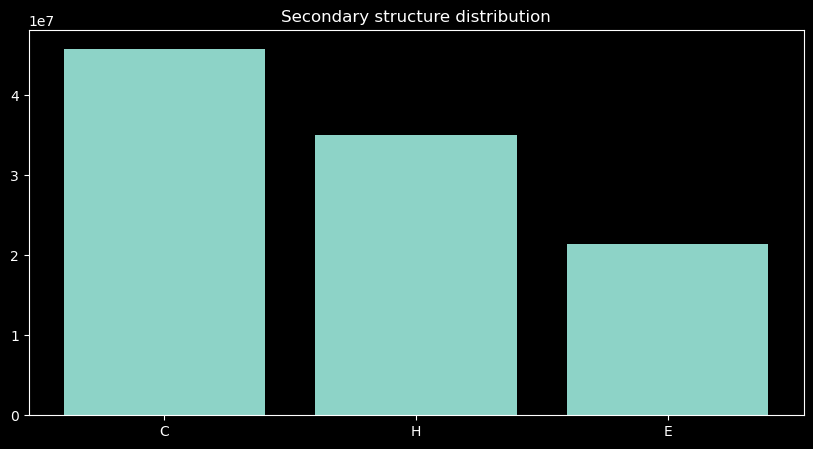

In [ ]:
# dataset - sst3
ss_count = {}
for ss in actual_ss:
    if ss not in ss_count:
        ss_count[ss] = 0
    else:
        ss_count[ss] += 1
print([round(c / sum(ss_count.values()), 4) for c in ss_count.values()])
mc = np.array(sorted(ss_count.items(), key=lambda x: x[1], reverse=True))
_, ax = plt.subplots(figsize=(10, 5))
ax.bar(mc[:, 0], np.array(mc[:, 1], dtype=int))
plt.title("Secondary structure distribution")
plt.show()

In [ ]:
total_ss = 8
all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss = get_sequences(input_csv_file, total_ss, csv_file=True)

[0.257, 0.0115, 0.1976, 0.1057, 0.0858, 0.0336, 0.3086, 0.0002]


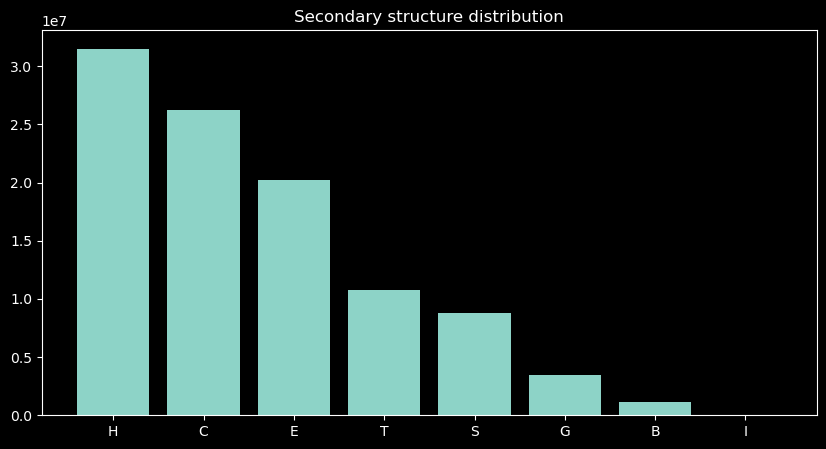

In [ ]:
# dataset - sst8
ss_count = {}
for ss in actual_ss:
    if ss not in ss_count:
        ss_count[ss] = 0
    else:
        ss_count[ss] += 1
print([round(c / sum(ss_count.values()), 4) for c in ss_count.values()])
mc = np.array(sorted(ss_count.items(), key=lambda x: x[1], reverse=True))
_, ax = plt.subplots(figsize=(10, 5))
ax.bar(mc[:, 0], np.array(mc[:, 1], dtype=int))
plt.title("Secondary structure distribution")
plt.show()

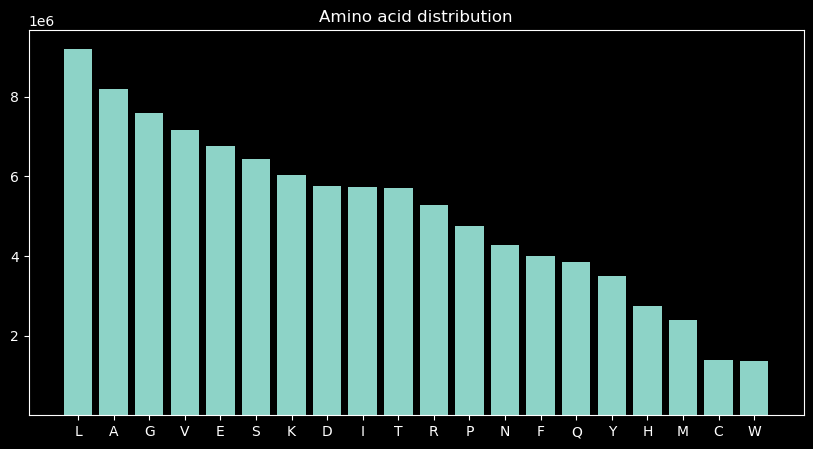

In [ ]:
aa_count = {}
for aa in actual_seq:
    if aa not in aa_count:
        aa_count[aa] = 0
    else:
        aa_count[aa] += 1
mc = np.array(sorted(aa_count.items(), key=lambda x: x[1], reverse=True))
_, ax = plt.subplots(figsize=(10, 5))
plt.bar(mc[:, 0], np.array(mc[:, 1], dtype=int))
plt.ylim(ymin=100)
plt.title("Amino acid distribution")
plt.show()

In [ ]:
class ProteinDataset(torch.utils.data.Dataset):
    def __init__(self, all_seq, all_ss, w_size, aa_onehot, ss_onehot_map):
        self.all_seq = all_seq
        self.all_ss = all_ss
        self.w_size = w_size
        self.aa_onehot = aa_onehot
        self.ss_onehot_map = ss_onehot_map

    def __len__(self):
        return len(self.all_seq) - self.w_size + 1

    def __getitem__(self, idx):
        seq_onehot = [self.aa_onehot[self.all_seq[aa]] for aa in range(idx, idx + self.w_size)]
        ss_onehot = self.ss_onehot_map[self.all_ss[idx + int(self.w_size / 2)]]
        return np.array(seq_onehot)[None], np.array(ss_onehot)

In [ ]:
class Net(nn.Module):
    def __init__(self, height, out_size):
        super(Net, self).__init__()
        self.height = height
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn_2d_a = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn_2d_b = nn.BatchNorm2d(64)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.rnn = nn.RNN(
            input_size=8,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
        )

        self.fc1 = nn.Linear(64 * int((self.height - 4) / 2) * 8, 128)
        self.bn_1d_a = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn_1d_b = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, out_size)

    def forward(self, x):
        x = self.relu(self.bn_2d_a(self.conv1(x)))
        x = self.relu(self.bn_2d_b(self.conv2(x)))

        x = self.dropout1(self.pool(x))

        x, h_n = self.rnn(x.view(-1, int((self.height - 4) / 2), 8), None)
        x = torch.flatten(x[:, -1, :], 1)
        x = x.view(128, -1)

        x = torch.flatten(x, 1)
        x = self.relu(self.bn_1d_a(self.fc1(x)))
        x = self.relu(self.bn_1d_b(self.fc2(x)))

        x = self.fc3(self.dropout2(x))

        return F.log_softmax(x, dim=1)

In [ ]:
def train_rnn(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate((train_loader)):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target.type(torch.LongTensor).cuda())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 5000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return running_loss / batch_idx

In [ ]:
def test_rnn(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in (test_loader):
            data, target = data.to(device, dtype=torch.float), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target.type(torch.LongTensor).cuda(), reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return correct / len(test_loader.dataset)

In [ ]:
def plot_to_figure(loss_values, accuracy_values, path):
    _, ax = plt.subplots(figsize=(10, 5))
    ax.plot(np.arange(1, 6).astype(int), loss_values, label="train loss")
    ax.plot(np.arange(1, 6).astype(int), accuracy_values, label="test accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss and Acc')
    plt.title('Train Loss and Test Accuracy')
    plt.savefig(path)
    plt.legend()
    plt.show()

In [ ]:
!mkdir -p models
!mkdir -p plots

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
plots_dir = "plots/"
models_dir = "models/"
w_size = 21
batch_size = 128

In [ ]:
def run_pipelines_rnn(max_epochs = 5):
    print("RNN Models Training\n")
    # dataset - sst3
    print("Traning for SST3 Type Structures\n\n")
    total_ss = 3

    all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss = get_sequences("../input/protein-secondary-structure/2018-06-06-pdb-intersect-pisces.csv", total_ss, csv_file=True)
    seq_train, seq_test, ss_train, ss_test = train_test_split(actual_seq, actual_ss, test_size=0.2, shuffle=False)

    train_dataset = ProteinDataset(seq_train, ss_train, w_size, aa_onehot_map, ss_map)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataset = ProteinDataset(seq_test, ss_test, w_size, aa_onehot_map, ss_map)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Net(w_size, total_ss).to(device)
#     summary(model, (1, w_size, 8))
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

    loss_values = []
    accuracy_values = []
    # test(model, device, test_loader)
    for epoch in tqdm(range(max_epochs)):
        train_loss = train_rnn(model, device, train_loader, optimizer, epoch)
        loss_values.append(train_loss)
        test_acc = test_rnn(model, device, test_loader)
        accuracy_values.append(test_acc)
        scheduler.step()

    torch.save(model.state_dict(), models_dir + "model_ss3.pth")
    plot_to_figure(loss_values, accuracy_values, plots_dir + "Q3_RNN_plot")

    # dataset - sst8
    print("Traning for SST8 Type Structures\n\n")
    total_ss = 8

    all_aa, aa_onehot_map, ss_map, ss_map_r, actual_seq, actual_ss = get_sequences("/kaggle/input/protein-secondary-structure/2018-06-06-pdb-intersect-pisces.csv", total_ss, csv_file=True)
    seq_train, seq_test, ss_train, ss_test = train_test_split(actual_seq, actual_ss, test_size=0.2, shuffle=False)

    train_dataset = ProteinDataset(seq_train, ss_train, w_size, aa_onehot_map, ss_map)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataset = ProteinDataset(seq_test, ss_test, w_size, aa_onehot_map, ss_map)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Net(w_size, total_ss).to(device)
#     summary(model, (1, w_size, 8))
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

    loss_values = []
    accuracy_values = []
    # test(model, device, test_loader)
    for epoch in tqdm(range(max_epochs)):
        train_loss = train_rnn(model, device, train_loader, optimizer, epoch)
        loss_values.append(train_loss)
        test_acc = test_rnn(model, device, test_loader)
        accuracy_values.append(test_acc)
        scheduler.step()

    torch.save(model.state_dict(), models_dir + "model_ss8.pth")
    plot_to_figure(loss_values, accuracy_values, plots_dir + "Q8_RNN_plot")

In [ ]:
def create_lstm_model(num_words, num_tags, lstm_layers=1, dropout_rate=.1, attention=True):
    input_tensor = Input(shape=(None,))
    x = Embedding(input_dim=num_words, output_dim=128)(input_tensor)

    # Add specified number of LSTM layers
    for i in range(lstm_layers):
        x = Bidirectional(LSTM(units=64, return_sequences=True))(x)
        x = Dropout(dropout_rate)(x)

    if attention:
        # Attention mechanism
        attention = Dense(1, activation='tanh')(x)
        attention = Activation('softmax')(attention)
        attention = Lambda(lambda x: x[0] * x[1])([x, attention])
        attention = Lambda(lambda x: K.sum(x, axis=1))(attention)
        attention = RepeatVector(2 * 64)(attention)
        attention = Permute([2, 1])(attention)

        # Concatenate attention vector with LSTM output
        x = Concatenate(axis=-1)([x, attention])

    y = TimeDistributed(Dense(num_tags, activation="softmax"))(x)
    model = Model(input_tensor, y)
    return model

In [ ]:
def create_transformer_model(num_words, num_tags, num_layers=2, d_model=64, num_heads=8, dff=512, dropout_rate=0.1):
    inputs = Input(shape=(None,), name='inputs')

    # Embedding layer
    embedding_layer = tf.keras.layers.Embedding(num_words, d_model)
    x = embedding_layer(inputs)

    # Positional encoding layer
    seq_length = tf.shape(inputs)[1]
    pos_encoding = positional_encoding(seq_length, d_model)
    x = x + pos_encoding
    x = Dropout(rate=dropout_rate)(x)

    # Transformer layers
    for i in range(num_layers):
        # Multi-head attention layer
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x, attention_mask=None)
        attention_output = Dropout(rate=dropout_rate)(attention_output)
        attention_output = LayerNormalization(epsilon=1e-6)(x + attention_output)

        # Position-wise feedforward layer
        feedforward_output = Dense(units=dff, activation='relu')(attention_output)
        feedforward_output = Dense(units=d_model)(feedforward_output)
        feedforward_output = Dropout(rate=dropout_rate)(feedforward_output)
        x = LayerNormalization(epsilon=1e-6)(attention_output + feedforward_output)

    # Output layer
    outputs = TimeDistributed(Dense(units=num_tags, activation='softmax'), name='outputs')(x)

    # Create model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
def positional_encoding(seq_length, d_model):
    position = K.arange(0, seq_length, dtype=K.floatx())
    position = K.expand_dims(position, 1)
    div_term = K.exp(K.arange(0, d_model, 2, dtype=K.floatx()) * -(np.log(10000.0) / d_model))
    div_term = K.expand_dims(div_term, 0)
    angles = K.dot(position, div_term)
    pos_encoding = K.concatenate([K.sin(angles), K.cos(angles)], axis=-1)
    pos_encoding = K.expand_dims(pos_encoding, 0)
    return pos_encoding

In [ ]:
def sequence_to_ngrams(seqs, n=3):
    """This function take a list of string as input and return a list of ngrams for each string"""
    return np.array([[seq[i:i + n] for i in range(len(seq))] for seq in seqs], dtype=object)

In [ ]:
# This method saves a tokenizer for later use
def save_tokenizer(file_path, tokenizer, encoding='utf-8'):
    # Extract directory path from file_path
    dir_path = os.path.dirname(file_path)

    # Check if the directory exists, create it if it doesn't
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    """This function saves a tokenizer for later use"""
    tokenizer_json = tokenizer.to_json()
    with io.open(file_path, 'w', encoding=encoding) as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
def get_data(file_path, max_sequence_length, input_column, target_column):
    """This method reads a csv file and return inputs and targets based on desired columns"""
    df = pd.read_csv(file_path)
    df.len.hist(bins=100)

    inputs, targets = df[[input_column, target_column]][
        (df.len <= max_sequence_length) & (~df.has_nonstd_aa)].values.T

    return inputs, targets

In [ ]:
def tokenize(data, char_level=False):
    tokenizer = Tokenizer(char_level=char_level)
    tokenizer.fit_on_texts(data)
    data = tokenizer.texts_to_sequences(data)
    return data, tokenizer

In [ ]:
def preprocess(data, max_sequence_length, train=True):
    """
    This method tokenizes the data and pads the data if it is shorter than maximum sequence length.
    If the data is target data it also transforms it into a one-hot vector using to_categorical
    """
    if train is True:
        data = sequence_to_ngrams(data)
        data, tokenizer = tokenize(data, char_level=False)
        data = pad_sequences(data, maxlen=max_sequence_length, padding='post')
        return data, tokenizer
    else:
        data, tokenizer = tokenize(data, char_level=True)
        data = pad_sequences(data, maxlen=max_sequence_length, padding='post')
        data = to_categorical(data)
        return data, tokenizer

In [ ]:
def acc(y_true, y_pred):
    '''
    This method calculates acc after masking padding (class = 0)
    :param y_true: True value of y. One-hot vector
    :param y_pred: Predicted value
    :return:
    '''
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

In [ ]:
def loss(y_true, y_pred):
    '''
    This method calculates loss after masking predictions where true labels where padding (class 0)
    :param y_true: True value of y. One hot vector
    :param y_pred: Predicted value
    :return:
    '''
    # Calculate the loss for each item in the batch.
    loss_fn = CategoricalCrossentropy(reduction='none')
    loss = loss_fn(y_true, y_pred)

    y = tf.argmax(y_true, axis=-1)

    # Mask off the losses on padding.
    mask = tf.cast(y != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [ ]:
def train_lstm(model, data, acc_metric, batch_size, loss_metric, dir_name=None, patience=10, max_epochs=50):
    x_train, x_val, y_train, y_val = data

    # Check if the directory exists, create it if it doesn't
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    model.compile(optimizer="rmsprop", loss=loss_metric, metrics=[acc_metric])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=f'val_{acc_metric}', patience=patience)
    model_checkpoints = keras.callbacks.ModelCheckpoint(f"{dir_name}/protein.h5", save_best_only=True)
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(x_val, y_val), verbose=1,
                        callbacks=[model_checkpoints, early_stopping])
    model.save(f'.{dir_name}/')

    model_history = pd.DataFrame(history.history)
    model_history['epoch'] = history.epoch

    return model_history

In [ ]:
def add_plot_to_figure(ax, name, model_history, metric_name):
    ax.plot(np.arange(0, model_history.shape[0]), model_history[metric_name],
            label=f"{name} train")
    ax.plot(np.arange(0, model_history.shape[0]), model_history[f"val_{metric_name}"],
            label=f"{name} val")
    ax.legend()
    return ax

In [ ]:
def run_pipelines_lstm_tf():
    print("LSTM and Transformer Models Training")
    input_csv_file = '../input/protein-secondary-structure/2018-06-06-ss.cleaned.csv'
    MAX_SEQUENCE_LENGTH = 128
    BATCH_SIZE = 1024
    MAX_EPOCHS = 50
    VAL_SIZE = 0.4
    RANDOM_STATE = 0

    input_sequences, q3_targets = get_data(file_path=input_csv_file, max_sequence_length=MAX_SEQUENCE_LENGTH,
                                           input_column='seq', target_column='sst3')

    _, q8_targets = get_data(file_path=input_csv_file, max_sequence_length=MAX_SEQUENCE_LENGTH,
                             input_column='seq', target_column='sst8')

    input_data, input_tokenizer = preprocess(data=input_sequences, max_sequence_length=MAX_SEQUENCE_LENGTH, train=True)
    q3_targets, q3_tokenizer = preprocess(data=q3_targets, max_sequence_length=MAX_SEQUENCE_LENGTH, train=False)
    q8_targets, q8_tokenizer = preprocess(data=q8_targets, max_sequence_length=MAX_SEQUENCE_LENGTH, train=False)

    input_dim = len(input_tokenizer.word_index) + 1
    output_dim_q3 = len(q3_tokenizer.word_index) + 1
    output_dim_q8 = len(q8_tokenizer.word_index) + 1

    x_train_q3, x_val_q3, y_train_q3, y_val_q3 = train_test_split(input_data, q3_targets, test_size=VAL_SIZE,
                                                                  random_state=RANDOM_STATE)

    x_train_q8, x_val_q8, y_train_q8, y_val_q8 = train_test_split(input_data, q8_targets, test_size=VAL_SIZE,
                                                                  random_state=RANDOM_STATE)

    save_tokenizer(file_path="tokenizer/ngram_tokenizer.json", tokenizer=input_tokenizer)
    save_tokenizer(file_path="tokenizer/q3_tokenizer.json", tokenizer=q3_tokenizer)
    save_tokenizer(file_path="tokenizer/q8_tokenizer.json", tokenizer=q8_tokenizer)

    data_q3 = x_train_q3, x_val_q3, y_train_q3, y_val_q3
    data_q8 = x_train_q8, x_val_q8, y_train_q8, y_val_q8

    lstm_config = {
        'prediction_types': ['Q3', 'Q8'],
        'lstm_layer_types': [1, 2],
        'attention_types': [True, False]
    }

    models_dir = "models/"
    plots_dir = "plots/"
    q3_models_results = []
    q8_models_results = []
    for prediction_type in lstm_config['prediction_types']:
        for lstm_layer_type in lstm_config['lstm_layer_types']:
            for attention_type in lstm_config['attention_types']:
                model_name = f"{prediction_type}_LSTM_{lstm_layer_type}L"
                if attention_type:
                    model_name += "_A"
                model = create_lstm_model(num_words=input_dim,
                                          num_tags=(output_dim_q3 if prediction_type == 'Q3' else output_dim_q8),
                                          lstm_layers=lstm_layer_type,
                                          attention=attention_type)
                print(model.summary())
                print(f"Training {model_name}")
                model_history = train_lstm(model=model,
                                      data=(data_q3 if prediction_type == 'Q3' else data_q8),
                                      acc_metric=acc,
                                      batch_size=BATCH_SIZE,
                                      loss_metric=loss,
                                      dir_name=models_dir + model_name,
                                      max_epochs=MAX_EPOCHS)

                if prediction_type == 'Q3':
                    q3_models_results.append([model_name, model_history])
                else:
                    q8_models_results.append([model_name, model_history])
                model.save(models_dir + model_name+".pth")

    transformer_config = {
        'prediction_types': ['Q3', 'Q8']
    }

    for prediction_type in transformer_config['prediction_types']:
        model_name = f"{prediction_type}_Transformer"
        model = create_transformer_model(num_words=input_dim,
                                  num_tags=(output_dim_q3 if prediction_type == 'Q3' else output_dim_q8))
        print(model.summary())
        print(f"Training {model_name}")
        model_history = train_lstm(model=model,
                              data=(data_q3 if prediction_type == 'Q3' else data_q8),
                              acc_metric=acc,
                              batch_size=BATCH_SIZE,
                              loss_metric=loss,
                              dir_name=models_dir + model_name,
                              max_epochs=MAX_EPOCHS)

        if prediction_type == 'Q3':
            q3_models_results.append([model_name, model_history])
        else:
            q8_models_results.append([model_name, model_history])

    fig, ax = plt.subplots(1, figsize=(8, 6))
    for result in q3_models_results:
        ax = add_plot_to_figure(ax, result[0], result[1], metric_name="acc")
    ax.legend()
    plt.tight_layout()
    plt.savefig(plots_dir + "Q3_LSTM_TF_accuracy_plot")
    plt.show()

    fig, ax = plt.subplots(1, figsize=(8, 6))
    for result in q8_models_results:
        ax = add_plot_to_figure(ax, result[0], result[1], metric_name="acc")
    ax.legend()
    plt.tight_layout()
    plt.savefig(plots_dir + "Q8_LSTM_TF_accuracy_plot")
    plt.show()

    fig, ax = plt.subplots(1, figsize=(8, 6))
    for result in q3_models_results:
        ax = add_plot_to_figure(ax, result[0], result[1], metric_name="loss")
    ax.legend()
    plt.tight_layout()
    plt.savefig(plots_dir + "Q3_LSTM_TF_loss_plot")
    plt.show()

    fig, ax = plt.subplots(1, figsize=(8, 6))
    for result in q8_models_results:
        ax = add_plot_to_figure(ax, result[0], result[1], metric_name="loss")
    ax.legend()
    plt.tight_layout()
    plt.savefig(plots_dir + "Q8_LSTM_loss_plot")
    plt.show()

RNN Models Training

Traning for SST3 Type Structures




  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/1765842 (0%)]	Loss: 1.206728
Train Epoch: 1 [640000/1765842 (36%)]	Loss: 0.945722
Train Epoch: 1 [1280000/1765842 (72%)]	Loss: 0.884493


 20%|██        | 1/5 [02:40<10:40, 160.05s/it]


Test set: Average loss: 0.8305, Accuracy: 277979/441446 (63%)

Train Epoch: 2 [0/1765842 (0%)]	Loss: 0.826146
Train Epoch: 2 [640000/1765842 (36%)]	Loss: 0.693267
Train Epoch: 2 [1280000/1765842 (72%)]	Loss: 0.858475


 40%|████      | 2/5 [05:14<07:50, 156.86s/it]


Test set: Average loss: 0.8015, Accuracy: 285273/441446 (65%)

Train Epoch: 3 [0/1765842 (0%)]	Loss: 0.800928
Train Epoch: 3 [640000/1765842 (36%)]	Loss: 0.723009
Train Epoch: 3 [1280000/1765842 (72%)]	Loss: 0.800425


 60%|██████    | 3/5 [07:50<05:12, 156.20s/it]


Test set: Average loss: 0.7861, Accuracy: 288359/441446 (65%)

Train Epoch: 4 [0/1765842 (0%)]	Loss: 0.823588
Train Epoch: 4 [640000/1765842 (36%)]	Loss: 0.852063
Train Epoch: 4 [1280000/1765842 (72%)]	Loss: 0.732081


 80%|████████  | 4/5 [10:27<02:36, 156.66s/it]


Test set: Average loss: 0.7814, Accuracy: 290033/441446 (66%)

Train Epoch: 5 [0/1765842 (0%)]	Loss: 0.770284
Train Epoch: 5 [640000/1765842 (36%)]	Loss: 0.733737
Train Epoch: 5 [1280000/1765842 (72%)]	Loss: 0.693066


100%|██████████| 5/5 [13:05<00:00, 157.11s/it]


Test set: Average loss: 0.7771, Accuracy: 290851/441446 (66%)



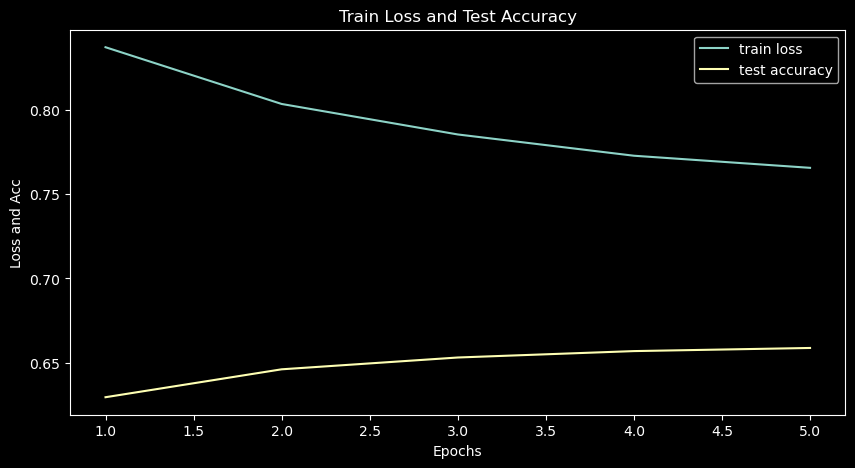

Traning for SST8 Type Structures




  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/1765842 (0%)]	Loss: 2.149414
Train Epoch: 1 [640000/1765842 (36%)]	Loss: 1.277183
Train Epoch: 1 [1280000/1765842 (72%)]	Loss: 1.303556


 20%|██        | 1/5 [02:38<10:34, 158.62s/it]


Test set: Average loss: 1.3689, Accuracy: 218147/441446 (49%)

Train Epoch: 2 [0/1765842 (0%)]	Loss: 1.457126
Train Epoch: 2 [640000/1765842 (36%)]	Loss: 1.398464
Train Epoch: 2 [1280000/1765842 (72%)]	Loss: 1.388583


 40%|████      | 2/5 [05:17<07:57, 159.05s/it]


Test set: Average loss: 1.3383, Accuracy: 223242/441446 (51%)

Train Epoch: 3 [0/1765842 (0%)]	Loss: 1.455557
Train Epoch: 3 [640000/1765842 (36%)]	Loss: 1.263648
Train Epoch: 3 [1280000/1765842 (72%)]	Loss: 1.274624


 60%|██████    | 3/5 [07:57<05:18, 159.10s/it]


Test set: Average loss: 1.3216, Accuracy: 226064/441446 (51%)

Train Epoch: 4 [0/1765842 (0%)]	Loss: 1.209946
Train Epoch: 4 [640000/1765842 (36%)]	Loss: 1.247907
Train Epoch: 4 [1280000/1765842 (72%)]	Loss: 1.210901


 80%|████████  | 4/5 [10:35<02:38, 158.95s/it]


Test set: Average loss: 1.3214, Accuracy: 226611/441446 (51%)

Train Epoch: 5 [0/1765842 (0%)]	Loss: 1.221355
Train Epoch: 5 [640000/1765842 (36%)]	Loss: 1.248122
Train Epoch: 5 [1280000/1765842 (72%)]	Loss: 1.053971


100%|██████████| 5/5 [13:14<00:00, 158.93s/it]


Test set: Average loss: 1.3133, Accuracy: 227842/441446 (52%)



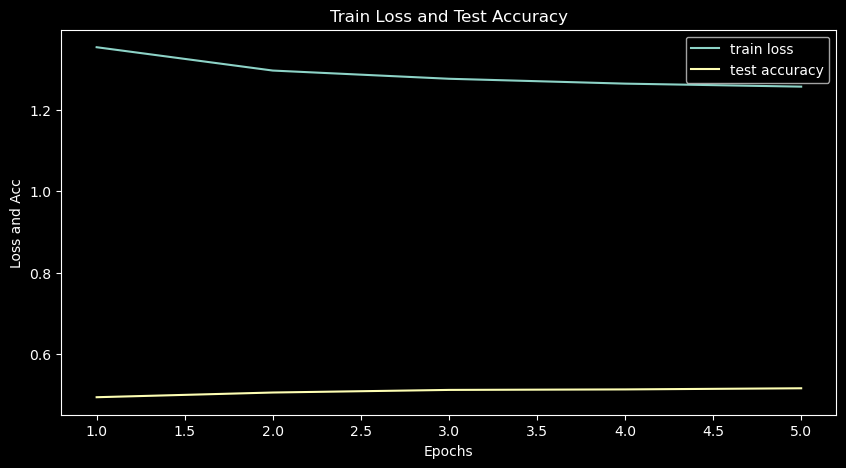

LSTM and Transformer Models Training
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    1077888     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 128)    98816       ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, None, 128)    0           ['bidirectional[0][0]']          
                                                         

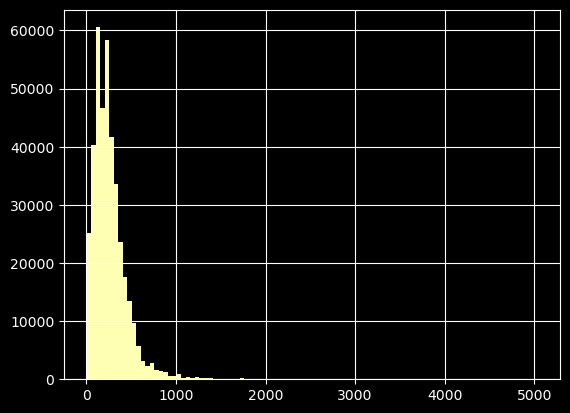

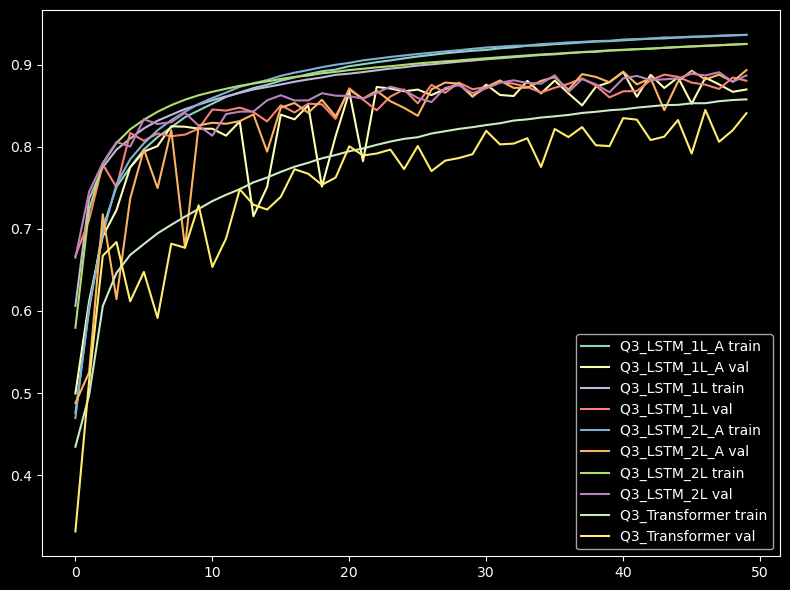

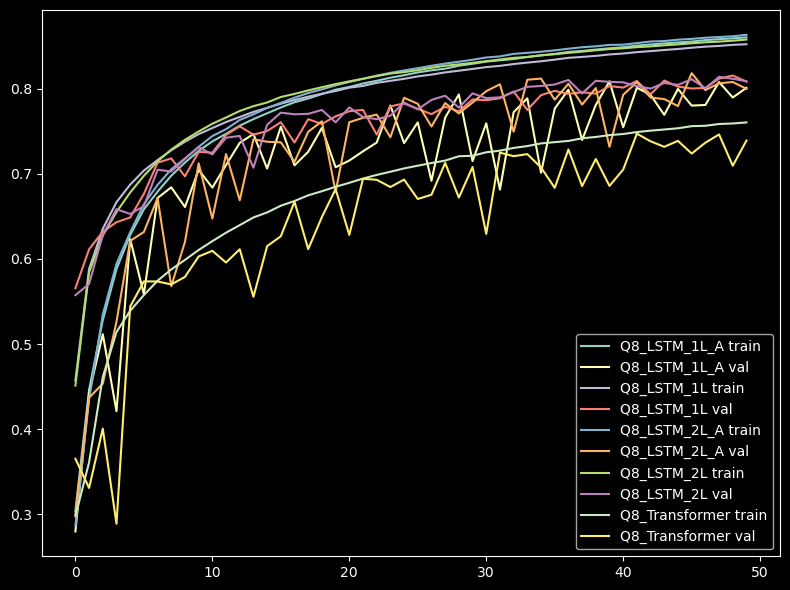

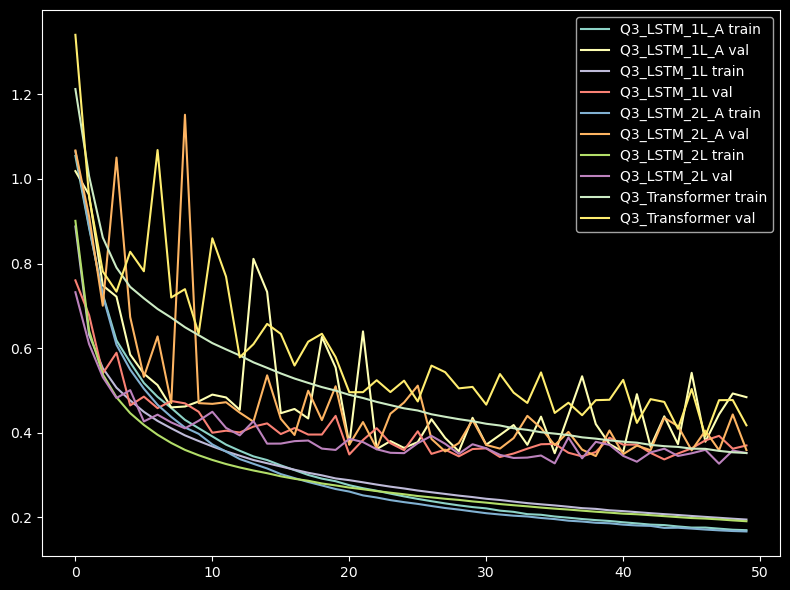

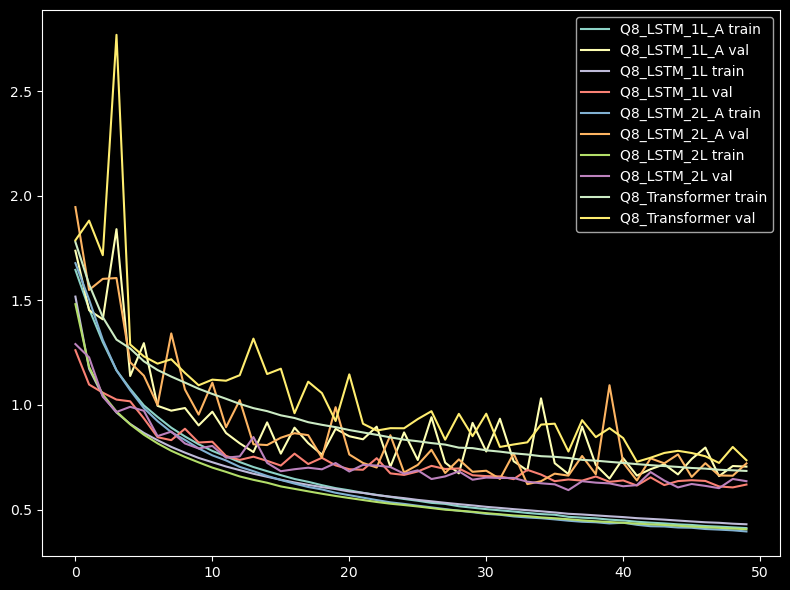

In [ ]:
if __name__ == "__main__":
    run_pipelines_rnn()
    run_pipelines_lstm_tf()